In [8]:
# instalação dos pacotes necessários
%pip install -U scikit-learn pandas numpy seaborn spacy --quiet
%pip install "https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.3.0/en_core_web_lg-3.3.0-py3-none-any.whl" --quiet
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


     ---------------------------------------- 1.0/1.0 MB 6.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [9]:
import  numpy as np
import  pandas as pd

import  spacy
from    spacy.tokens import Span

from    sklearn.model_selection import train_test_split
from    sklearn.feature_extraction.text import CountVectorizer
from    sklearn.metrics import accuracy_score, precision_score, recall_score
from    sklearn.pipeline import Pipeline

from    sklearn.tree import DecisionTreeClassifier
from    sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from    sklearn.linear_model import LogisticRegressionCV
from    sklearn.svm import SVC
import  lightgbm as lgb

import  seaborn as sns
import  matplotlib.pyplot as plt

In [10]:
#silenciar o sklearn
from    warnings import simplefilter
from    sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=UndefinedMetricWarning)

In [11]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
# Créditos do código: João Rodrigues
def multi_classifier_fit_score(cleaner, vectorizer, classifiers: dict, X, y) -> dict:
    """
    Fit and Test multiple classifiers at the same time
    Returns a dictonary of scores and a dictionary of all fitted pipelines accessable by the key of the classifiers' dict

    Arguments:
      cleaner: a pipeline-ready object to clean data
      vectorizer: a pipeline-ready object to vectorize the data
      classifiers: a dictionary of classifiers to fit and score {'estimator_name': estimator()}
      X: features that explain the target
      y: target

    Returns:
      scores(dict): a dictionary where keys are the classifiers' names inside the classifiers dict and the values are lists
        with accuracy, precision and recall scores.
      models(dict): a dictionary where the keys are the classifiers' names inside the classifiers dict and the values are 
        all the models fitted by this function
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    from sklearn.model_selection import train_test_split

    scores = {}
    models = {}

    X_train_mcfs, X_test_mcfs, y_train_mcfs, y_test_mcfs = train_test_split(
        X, y, test_size=0.3, random_state=10)

    for index, classifier in enumerate(classifiers):
        classifier_ready = classifiers[classifier]

        pipe_multi_classifier = Pipeline(
            steps=[('cleaner', cleaner),
                   ('vectorizer', vectorizer),
                   ('classifier', classifier_ready)]
        )

        pipe_multi_classifier.fit(X_train_mcfs, y_train_mcfs)

        y_pred_mcfs = pipe_multi_classifier.predict(X_test_mcfs)

        scores[classifier] = [
            (round(accuracy_score(y_test_mcfs, y_pred_mcfs), 3)),
            (round(precision_score(y_test_mcfs, y_pred_mcfs, average='weighted'), 3)),
            (round(recall_score(y_test_mcfs, y_pred_mcfs, average='weighted'), 3))
        ]

        models[classifier] = pipe_multi_classifier

    return scores, models


In [19]:
# Créditos do código: João Rodrigues
def best_model(scores: dict, metric: str = 'accuracy') -> list:
    """
    Checks a dictionary of estimators scores and return a list containing the best model

    Arguments:
      scores: {'estimator': [accuracy, precision, recall]}
      metric: accuracy | precision | recall

    Returns:
      list['estimator', 'score', 'metric']
    """
    metrics_dict = {
        'accuracy': 0,
        'precision': 1,
        'recall': 2
    }

    if metric not in metrics_dict.keys():
        metric = 'accuracy'

    position = metrics_dict[metric]

    melhor_modelo = []

    for name, score in scores.items():
        if len(melhor_modelo) == 0:
            melhor_modelo = [name, score[position]]

        if (score[position] >= melhor_modelo[1]):
            melhor_modelo = [name, score[position]]

    melhor_modelo.append(metric)
    return melhor_modelo

def multi_classifier_fit_score(cleaner, vectorizer, classifiers: dict, X, y) -> dict:
  """
  Fit and Test multiple classifiers at the same time
  Returns a dictonary of scores and a dictionary of all fitted pipelines accessable by the key of the classifiers' dict

  Arguments:
    cleaner: a pipeline-ready object to clean data
    vectorizer: a pipeline-ready object to vectorize the data
    classifiers: a dictionary of classifiers to fit and score {'estimator_name': estimator()}
    X: features that explain the target
    y: target
  
  Returns:
    scores(dict): a dictionary where keys are the classifiers' names inside the classifiers dict and the values are lists
      with accuracy, precision and recall scores.
    models(dict): a dictionary where the keys are the classifiers' names inside the classifiers dict and the values are 
      all the models fitted by this function
  """
  from sklearn.metrics import accuracy_score, precision_score, recall_score
  from sklearn.model_selection import train_test_split

  scores = {}
  models = {}

  X_train_mcfs, X_test_mcfs, y_train_mcfs, y_test_mcfs = train_test_split(X, y, test_size=0.3, random_state=10)

  for index, classifier in enumerate(classifiers):
    classifier_ready = classifiers[classifier]
  
    pipe_multi_classifier = Pipeline(
    steps=[('cleaner', cleaner),
          ('vectorizer', vectorizer),
          ('classifier', classifier_ready)]
    )

    pipe_multi_classifier.fit(X_train_mcfs, y_train_mcfs)
    
    y_pred_mcfs = pipe_multi_classifier.predict(X_test_mcfs)
    
    scores[classifier] = [
      (round(accuracy_score(y_test_mcfs, y_pred_mcfs), 3)), 
      (round(precision_score(y_test_mcfs, y_pred_mcfs, average='weighted'), 3)), 
      (round(recall_score(y_test_mcfs, y_pred_mcfs, average='weighted'), 3))
    ]

    models[classifier] = pipe_multi_classifier
  
  return scores, models

#### 1. Construa as funções e a pipeline, separe os dados em treino e teste, execute a pipeline para classificar em positivo, negativo e neutro. Quais foram os valores de acurácia, precisão e sensitividade deste modelo? (3.0 pontos)

In [22]:
def prepare_text(text):     
    return text.strip().lower()

class predictors():
    def transform(self, X, **transform_params):
        return [prepare_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

def tokenizer(text):
    doc = nlp(text)
    tokens = [token for token in doc if ((not token.is_stop) & (not token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    return tokens

vectorizer = CountVectorizer(tokenizer = tokenizer, ngram_range=(1,1), dtype=np.float64)


In [14]:
#Getting data
financial = pd.read_csv('https://github.com/lucascarneirodev/Data-Science-Projects/raw/main/M%C3%B3dulo%2003/Projeto%2003/data.csv')

In [13]:
x = financial.Sentence
y = financial.Sentiment

In [24]:
classifiers = {
              'LGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42), 
              'SVC': SVC(random_state=42), 
              'RandomForest': RandomForestClassifier(random_state=42), 
              'AdaBoost': AdaBoostClassifier(DecisionTreeClassifier(random_state=42), n_estimators=100, random_state=42),
              'LogisticRegression': LogisticRegressionCV(cv=5, solver='sag', random_state=42, n_jobs=-1),
              'GradientBoosting': GradientBoostingClassifier(random_state=42)
              }

In [25]:
scores, models = multi_classifier_fit_score(cleaner= predictors(), vectorizer= vectorizer, classifiers=classifiers, X = financial.Sentence, y = financial.Sentiment)

scores

{'LGBM': [0.674, 0.659, 0.674],
 'SVC': [0.674, 0.65, 0.674],
 'RandomForest': [0.673, 0.655, 0.673],
 'AdaBoost': [0.663, 0.659, 0.663],
 'LogisticRegression': [0.682, 0.668, 0.682],
 'GradientBoosting': [0.693, 0.679, 0.693]}

In [31]:
greatest_model = best_model(scores, metric='accuracy')
greatest_model

['GradientBoosting', 0.693, 'accuracy']

In [32]:
acc = scores['GradientBoosting'][0]
prec = scores['GradientBoosting'][1]
rec = scores['GradientBoosting'][2]

print(f'''
Best model: {greatest_model[0]}
Score:
    Accuracy: {acc}
    Precision: {prec}
    Recall: {rec}
''')



Best model: GradientBoosting
Score:
    Accuracy: 0.693
    Precision: 0.679
    Recall: 0.693



#### 2. Use o seu modelo para classificar os seguintes textos extraídos do site Financial Times. Faça uma tabela com o valor esperado e o valor obtido, e responda: houve divergência entre o esperado e o obtido? O que poderia ser feito para corrigir? (1.0 ponto)
a. Central banks’ rate rises, geopolitical risk and slowing growth trigger investors’ stampede for safety. resultado esperado: [negativo]

b. China opens up bond market in bid to woo foreign investors. resultado esperado: [neutro]

c. HM Revenue & Customs says residents had £850bn in accounts overseas but it does not estimate if tax paid on this. resultado esperado: [negativo]

d. Japan’s horrifying crop of data falsification is also encouraging. The scandals have emerged from a distinct new phase in the evolution of the country’s shareholder capitalism. resultado esperado: [negativo]

e. Despite internal problems, the group continues to exert a tight grip on the US’s gun control debate. resultado esperado: [neutro]

In [27]:
sentence_data = {
                  "Sentence": ["Central banks’ rate rises, geopolitical risk and slowing growth trigger investors’ stampede for safety.",
                          "China opens up bond market in bid to woo foreign investors.",
                          "HM Revenue & Customs says residents had £850bn in accounts overseas but it does not estimate if tax paid on this.",
                          "Japan’s horrifying crop of data falsification is also encouraging. The scandals have emerged from a distinct new phase in the evolution of the country’s shareholder capitalism.",
                          "Despite internal problems, the group continues to exert a tight grip on the US’s gun control debate."],
                  "Sentiment": ["negative", "neutral", "negative", "negative", "neutral"]        
                          }
                          
sentence_data = pd.DataFrame(sentence_data)

sentence_data.head()

,Sentence,Sentiment
0,"Central banks’ rate rises, geopolitical risk a...",negative
1,China opens up bond market in bid to woo forei...,neutral
2,HM Revenue & Customs says residents had £850bn...,negative
3,Japan’s horrifying crop of data falsification ...,negative
4,"Despite internal problems, the group continues...",neutral


In [33]:
models[greatest_model[0]]

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x0000020E7CB85630>),
                ('vectorizer',
                 CountVectorizer(dtype=<class 'numpy.float64'>,
                                 tokenizer=<function tokenizer at 0x0000020E005D5870>)),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [71]:
y_pred = models[greatest_model[0]].predict(sentence_data.Sentence)
print(round(accuracy_score(sentence_data.Sentiment, y_pred), 3))
print(round(precision_score(sentence_data.Sentiment, y_pred, average='macro'), 3))
print(round(recall_score(sentence_data.Sentiment, y_pred, average='macro'), 3))

0.4
0.167
0.333


In [72]:
sentences = sentence_data['Sentence']
sentiments = sentence_data['Sentiment']
sentiments_pred = y_pred

values_dict = {"Sentence": sentences, "Original Sentiment": sentiments, "Predicted Sentiment": sentiments_pred}

results_sentence = pd.DataFrame(values_dict)

results_sentence['Divergence'] = results_sentence["Predicted Sentiment"] != results_sentence["Original Sentiment"]

results_sentence

,Sentence,Original Sentiment,Predicted Sentiment,Divergence
0,"Central banks’ rate rises, geopolitical risk a...",negative,positive,True
1,China opens up bond market in bid to woo forei...,neutral,neutral,False
2,HM Revenue & Customs says residents had £850bn...,negative,neutral,True
3,Japan’s horrifying crop of data falsification ...,negative,neutral,True
4,"Despite internal problems, the group continues...",neutral,neutral,False


In [47]:
results_sentence['Divergence'].value_counts()

True     3
False    2
Name: Divergence, dtype: int64

#### 3. Faça uma análise exploratória, onde identifique as três empresas mais citadas e quantifique os níveis de positividade, negatividade e neutralidade dos textos sobre estas empresas. (3.0 pontos)

##### a. Extraia de todos os textos as entidades, há quantas entidades? (0.6 pontos) 

In [49]:
entities = 0
for row in range(financial.shape[0]):
  doc = nlp(financial.Sentence[row])
  for ent in doc.ents:
    entities += 1

entities

15408

##### b. Quantas entidades são empresas? (0.6 pontos)

In [83]:
cleaning_list = ['EUR', '65mn', 'Group', 'Location Based Search Technology']
orgs = {'original_index': [], 'entity': [], 'sentiment': []}
for row in range(financial.shape[0]):
  doc = nlp(financial.Sentence[row])
  new_labels = []
  index = -1
  for token in doc:
    index += 1
    if token.text in cleaning_list:
      new_labels.append(Span(doc, index, index+1, label="OTHER"))
      doc.set_ents(new_labels, default="unmodified")
  for ent in doc.ents:
    if ent.label_ == 'ORG':
      orgs['original_index'].append(row)
      orgs['entity'].append(ent.text)
      orgs['sentiment'].append(financial.Sentiment[row])
    

entities = pd.DataFrame(orgs)
entities.head()

,original_index,entity,sentiment
0,0,GeoSolutions,positive
1,0,Location Based Search Technology,positive
2,1,ESI,negative
3,1,BK,negative
4,2,Componenta,positive


In [74]:
entities.entity.shape

(4606,)

##### c. Quais são as três empresas mais citadas? (0.6 pontos)

In [92]:
entities.entity.value_counts()

Nokia                     63
AAPL                      40
Finnair                   29
Tesco                     29
FTSE                      26
                          ..
Top Post                   1
Hillshire Farms            1
ConAgra Names              1
Pioneer Library System     1
Nordic Walking             1
Name: entity, Length: 2664, dtype: int64

##### d. Faça uma tabela onde demonstre as três empresas mais citadas e o total de textos positivos, negativos e neutros de cada uma. (1.2 pontos)

In [93]:
most_quoted = ['FTSE', 'Tesco', 'AAPL']
sentiments = ['neutral', 'negative', 'positive']
total_val = {'FTSE': {}, 'Tesco': {}, 'AAPL': {}}

for brand in most_quoted:
  df = entities[entities['entity'] == brand]
  df = df.drop('original_index', axis=1)

  for sentiment in sentiments:
    count = df[df['sentiment'] == sentiment].value_counts()
    count = pd.DataFrame(count)
    count.reset_index(inplace=True)
    count.columns = ['entity', 'sentiment', 'count']
    count.drop(['entity', 'sentiment'], axis=1, inplace=True)
    total_val[brand][sentiment] = int(count['count'].to_string()[1:].strip())
  
total_val = pd.DataFrame(total_val)
total_val.reset_index(inplace=True)
total_val.columns = ['sentiment'] + most_quoted
total_val = total_val[[column for column in total_val if column not in ['sentiment']] + ['sentiment']]
total_val

,FTSE,Tesco,AAPL,sentiment
0,2,3,2,neutral
1,11,11,11,negative
2,13,15,27,positive


#### 4. Faça gráficos a partir da tabela obtida acima. Descreva cada gráfico de forma que estivesse apresentando à diretoria dessas três empresas. (3.0 pontos)

<AxesSubplot:xlabel='sentiment', ylabel='Nokia'>

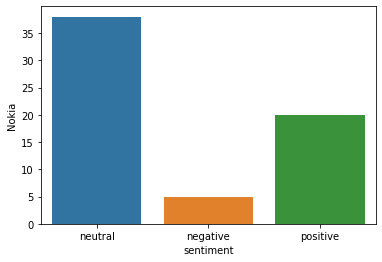

In [61]:
sns.barplot(x='sentiment', y='FTSE', data=total_val)

Com base na análise de sentimento dos dados coletados, podemos afirmar que a marca é vista de forma majoritariamente positiva/neutra pela mídia.

<AxesSubplot:xlabel='sentiment', ylabel='AAPL'>

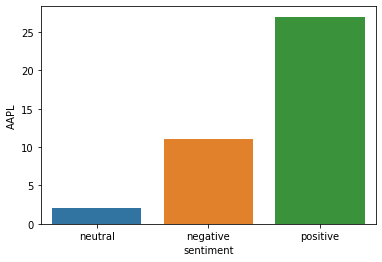

In [62]:
sns.barplot(x='sentiment', y='Tesco', data=total_val)

Através da análise dos dados coletados para análise de sentimento da mídia em relação a empresa AAPL, podemos observar que a empresa é vista de forma majoritariamente positiva pela mídia.

<AxesSubplot:xlabel='sentiment', ylabel='Finnair'>

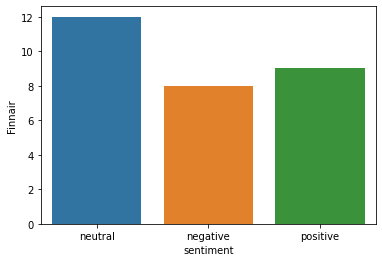

In [63]:
sns.barplot(x='sentiment', y='AAPL', data=total_val)

Com os dados coletados sobre a empresa Finnair, conseguimos concluir que a empresa é vista de forma neutra ou positiva pela mídia especializada, ainda assim há uma quantidade considerável de publicações negativas a respeito que devem ser consideradas para as campanhas de marketing futuras.